In [1]:
import polars as pl
import glob
import pandas as pd
from scipy.stats import skew 
from scipy.stats import kurtosis 
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
%matplotlib inline

# Step 0: Read in Data (2022)

In [2]:
path = 'D:\\qr_takehome\\'

In [3]:
data = []
for file_name in glob.glob(path+'*.parquet'):
    print(file_name)
    x = pl.read_parquet(file_name, low_memory=False).to_pandas()
    data.append(x)

D:\qr_takehome\QR_TAKEHOME_20220103.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220104.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220105.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220106.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220107.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220110.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220111.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220112.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220113.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220114.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220118.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220119.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220120.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220121.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220124.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220125.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220126.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220127.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220131.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220201.csv.parquet
D:\qr_takehome\QR_TAKEHOME_20220202.csv.

In [4]:
data = pd.concat(data, axis=0, ignore_index=True)

In [5]:
data

,time,sym,exch,Q1,Q2,X1,X10,X100,X101,X102,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
0,35101000,SPX,cme,1.00,1.00,-1.985130,-0.440099,0.044736,-0.010772,-0.453612,...,-0.496673,-0.419372,-2.094251,-0.544180,0.947544,-2.114019,-0.783769,-0.229752,-4.967191e+01,-61.707756
1,35102000,SPX,cme,1.00,1.00,-0.933646,-0.380986,-0.854499,-0.951011,-0.622912,...,-0.657351,-0.689837,-2.004462,-1.462824,-0.014917,-2.296994,-1.078146,-0.137521,-4.889528e+01,-62.025402
2,35103000,SPX,cme,1.00,1.00,-0.579249,-0.180915,-0.854372,-0.969687,-0.320432,...,-0.350017,-0.383252,-1.690756,-1.482096,-0.056237,-2.001233,-0.784774,0.171525,-4.706744e+01,-57.324017
3,35104000,SPX,cme,1.00,1.00,-0.658292,-0.028344,-0.044026,-0.496256,-0.057465,...,-0.085383,0.085024,-1.307463,-0.672521,0.405438,-1.738940,-0.313380,0.541654,-4.759041e+01,-58.769417
4,35105000,SPX,cme,1.00,1.00,-1.331419,-0.100419,0.273158,0.218558,0.373589,...,0.342332,0.306470,-1.260183,-0.348818,1.124927,-1.298653,-0.081095,0.575009,-4.811086e+01,-59.984489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399995,57596000,SPX,cme,0.21,0.21,0.409574,0.832771,NaN,-0.171320,NaN,...,NaN,0.679342,-0.392610,NaN,-0.854024,NaN,0.230086,0.053598,-6.473958e-01,-0.226799
5399996,57597000,SPX,cme,0.21,0.21,-0.367065,0.707371,NaN,0.381288,NaN,...,NaN,0.679435,-0.607495,NaN,-0.292392,NaN,0.254040,-0.157832,-1.294708e+00,-1.247265
5399997,57598000,SPX,cme,0.21,0.21,0.888878,0.004432,NaN,-0.718691,NaN,...,NaN,-0.407149,-0.468149,NaN,-1.408626,NaN,-0.846575,-0.018240,-1.177682e-12,1.134147
5399998,57599000,SPX,cme,0.21,0.12,-0.571117,0.142959,NaN,0.609560,NaN,...,NaN,0.219540,-0.585420,NaN,-0.066102,NaN,-0.212063,-0.132636,-6.473958e-01,-0.226799


# Step 1: Exploratory Data Analysis

### 1. EDA on $Y_1$ and $Y_2$

a. Distribution

<AxesSubplot:>

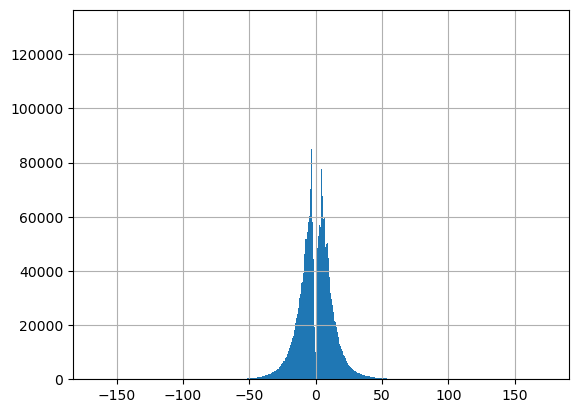

In [6]:
data['Y1'].hist(bins=1000)

<AxesSubplot:>

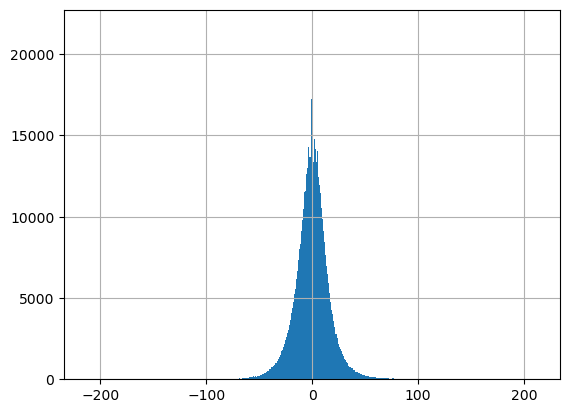

In [7]:
data['Y2'].hist(bins=5000)

b. Count and Missing

In [8]:
count_ = len(data['Y1'])
count_

5400000

In [9]:
missing_Y1 = data['Y1'].isna().sum() + data[data['Y1'] == 999999]['Y1'].count()
missing_Y2 = data['Y2'].isna().sum() + data[data['Y2'] == 999999]['Y2'].count()
print(missing_Y1, missing_Y2)

0 0


c. Skew and Kurtosis

In [10]:
[skew(data['Y1']), skew(data['Y2'])]

[0.07074568662139025, 0.10350293514404854]

In [11]:
[kurtosis(data['Y1']), kurtosis(data['Y2'])]

[5.633556022456959, 5.13951639135324]

d.Stationary 

In [12]:
data[['Y1','Y2']].corr()

,Y1,Y2
Y1,1.0000,0.9585
Y2,0.9585,1.0000


<AxesSubplot:>

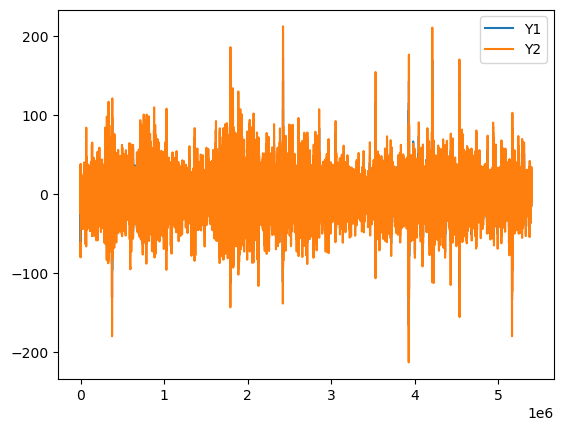

In [13]:
data[['Y1','Y2']].plot()

<AxesSubplot:>

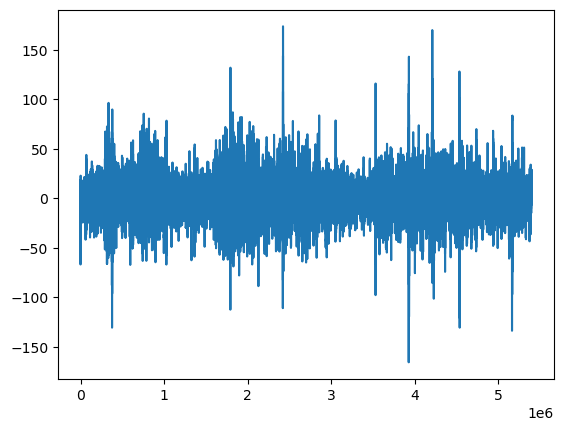

In [15]:
data['Y1'].plot()

In [16]:
data['Y1'].describe()

count    5.400000e+06
mean    -2.657250e-02
std      1.269225e+01
min     -1.658715e+02
25%     -6.630640e+00
50%      0.000000e+00
75%      6.615288e+00
max      1.738783e+02
Name: Y1, dtype: float64

In [17]:
data['Y2'].describe()

count    5.400000e+06
mean    -6.734135e-02
std      1.659299e+01
min     -2.128123e+02
25%     -8.837571e+00
50%      9.408179e-02
75%      8.678277e+00
max      2.126009e+02
Name: Y2, dtype: float64

In [19]:
data_open = data[data['time'] == 35101000]
data_mid = data[data['time'] == 46351000]
data_close = data[data['time'] == 57600000]

In [20]:
data_open_Y1 = data_open['Y1']
data_open_Y2 = data_open['Y2']
data_mid_Y1 = data_mid['Y1']
data_mid_Y2 = data_mid['Y2']
data_close_Y1 = data_close['Y1']
data_close_Y2 = data_close['Y2']

<AxesSubplot:>

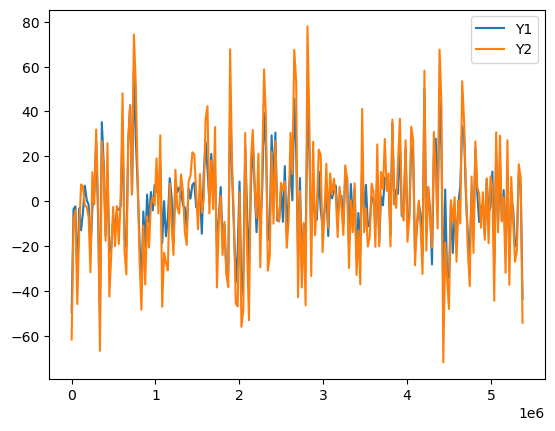

In [21]:
data_open[['Y1','Y2']].plot()

<AxesSubplot:>

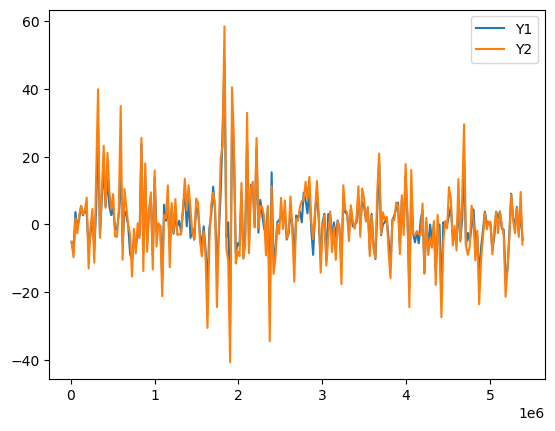

In [22]:
data_mid[['Y1','Y2']].plot()

<AxesSubplot:>

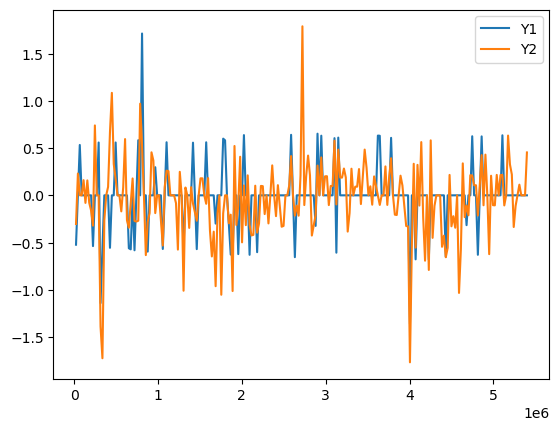

In [23]:
data_close[['Y1','Y2']].plot()

In [ ]:
res = adfuller(data_open_Y2)

In [ ]:
res

### 2. EDA on $X_1$ ~ $X_{375}$

a. Missing

In [24]:
missing_x = []
for i in range(375):
    x = data[data.columns[5 + i]]
    na_count = x[x == 999999].count() + x.isna().sum()
    missing_x.append([i + 1, na_count/count_])

In [25]:
missing_x = pd.DataFrame(missing_x)
missing_x.columns = ['Feature', 'Missing Count']

In [26]:
missing_x.sort_values(by='Missing Count')

,Feature,Missing Count
81,82,0.000000
62,63,0.000000
61,62,0.000000
60,61,0.000000
59,60,0.000000
...,...,...
272,273,0.044232
271,272,0.044232
210,211,0.044232
201,202,0.044232


In [27]:
missing_x['Missing Count'].describe()

count    375.000000
mean       0.024533
std        0.018449
min        0.000000
25%        0.000483
50%        0.036617
75%        0.042181
max        0.044232
Name: Missing Count, dtype: float64

b.stationary

In [30]:
data = data.fillna(method='ffill')

In [53]:
data_open = data[data['time'] == 35501000]
data_mid = data[data['time'] == 46351000]
data_close = data[data['time'] == 57000000]

In [54]:
data_close

,time,sym,exch,Q1,Q2,X1,X10,X100,X101,X102,...,X92,X93,X94,X95,X96,X97,X98,X99,Y1,Y2
21899,57000000,SPX,cme,1.0,1.00,0.376787,0.466303,0.514036,0.074115,-0.274784,...,-0.297529,-0.245634,0.037154,0.560870,0.191941,0.366987,0.456381,-0.417924,-3.134714,0.455011
44399,57000000,SPX,cme,1.0,0.12,0.697611,-0.079001,0.075970,-0.396960,-0.392594,...,-0.372794,-0.456776,-0.048771,-0.105579,-0.644714,-0.356100,-0.431545,-0.054116,-8.864554,-11.268081
66899,57000000,SPX,cme,1.0,1.00,-1.008002,0.251906,0.308190,0.163302,0.719868,...,0.617083,0.331714,-0.485117,0.509486,0.483433,1.276164,0.313527,-0.497735,0.531533,-7.267212
89399,57000000,SPX,cme,1.0,1.00,0.131336,0.779205,1.517104,1.209436,1.189974,...,1.175027,1.063227,0.604407,1.502709,1.210144,1.409581,1.447961,0.528478,-3.733632,-6.585420
111899,57000000,SPX,cme,1.0,1.00,-0.481774,-0.004003,0.697519,0.769919,0.553991,...,0.531784,0.499761,0.040570,0.830112,0.971129,0.404549,0.385950,0.088629,-10.690328,-16.322090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5309399,57000000,SPX,cme,1.0,1.00,0.271173,0.055606,0.317067,-0.176565,-0.416626,...,-0.431860,-0.197093,0.142966,0.234792,-0.014628,-0.003438,0.139934,0.179069,4.524741,5.646974
5331899,57000000,SPX,cme,1.0,0.21,0.044246,0.777541,0.133170,0.272683,-0.017753,...,-0.004097,0.660994,0.545481,0.653292,0.089947,-0.066010,1.064931,0.095995,-8.420507,-9.486907
5354399,57000000,SPX,cme,1.0,1.00,0.599512,-0.422591,-0.015190,-0.137037,-0.628009,...,-0.504516,-0.117545,0.719255,0.717784,-0.592303,-0.747586,-0.246912,0.508259,-3.937395,-9.510334
5376899,57000000,SPX,cme,1.0,1.00,0.710335,0.274632,-0.725137,-0.328797,-0.200932,...,-0.217151,-0.438446,-0.146285,-1.327741,-0.571316,0.051419,-0.052138,-0.233397,-0.644766,-8.022055


In [55]:
res_X = []
for i in range(375):
    x = data.columns[5+i]
    data_open_X = data_open[x]
    data_mid_X = data_mid[x]
    data_close_X = data_close[x]
    res_open = adfuller(data_open_X)[1]
    res_mid = adfuller(data_mid_X)[1]
    res_close = adfuller(data_close_X)[1]
    res_X.append([res_open,res_mid,res_close])

In [56]:
res_X = pd.DataFrame(np.array(res_X).T,columns = data.columns[5:380]).T
res_X.columns = ['Open', 'Mid', 'Close']

In [57]:
res_X[res_X['Open']>0.05]['Open']

X118    0.074905
X120    0.639558
X2      0.231650
X230    0.288679
Name: Open, dtype: float64

In [58]:
res_X[res_X['Mid']>0.05]['Mid']

Series([], Name: Mid, dtype: float64)

In [52]:
res_X[res_X['Close']>0.05]['Close']

Series([], Name: Close, dtype: float64)

### 3. EDA on $Q_1$ and $Q_2$

In [59]:
data['Q1'].describe()

count    5.400000e+06
mean     9.650248e-01
std      1.672042e-01
min      2.000000e-02
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Q1, dtype: float64

In [60]:
data['Q2'].describe()

count    5.400000e+06
mean     9.609689e-01
std      1.690351e-01
min      2.000000e-02
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: Q2, dtype: float64

In [64]:
data[['Y1','Q1','Y2','Q2','time']].corr()

,Y1,Q1,Y2,Q2,time
Y1,1.000000,0.004289,0.958500,0.000503,0.007738
Q1,0.004289,1.000000,0.004546,0.332604,0.013469
Y2,0.958500,0.004546,1.000000,0.004350,0.009934
Q2,0.000503,0.332604,0.004350,1.000000,-0.094711
time,0.007738,0.013469,0.009934,-0.094711,1.000000
